In [58]:
import os
import pandas as pd

def get_subfolder_names(main_folder_path):
    # List to store the subfolder names
    
    file_names = []
    subfolder_names = []

    # Iterate through the folder_ID contents
    for folder_ID in os.listdir(main_folder_path):

        subfolder_path = main_folder_path + '/' + folder_ID
        
        for file_ID in os.listdir(subfolder_path):
            
            if os.path.isdir(os.path.join(main_folder_path, folder_ID)):
                subfolder_names.append(folder_ID)

            if os.path.isfile(os.path.join(subfolder_path, file_ID)):
                file_names.append(file_ID)
    
    return [subfolder_names, file_names]

# Example usage:
main_folder_path = "C:/Users/ryan_/OneDrive/Documents/USF/Courses/Fall 2024/Mobile Biometrics/Project/Voice Recognition/data"
subfolders = get_subfolder_names(main_folder_path)[0]
fileNames = get_subfolder_names(main_folder_path)[1]

data = {'Label':subfolders, 'File Name':fileNames}

df = pd.DataFrame(data)



# Display the list of subfolder names
#print("Subfolders found:", subfolders)
#print(fileNames)


print(df)

      Label    File Name
0        01   0_01_0.wav
1        01   0_01_1.wav
2        01  0_01_10.wav
3        01  0_01_11.wav
4        01  0_01_12.wav
...     ...          ...
29995    60   9_60_5.wav
29996    60   9_60_6.wav
29997    60   9_60_7.wav
29998    60   9_60_8.wav
29999    60   9_60_9.wav

[30000 rows x 2 columns]


9999
0


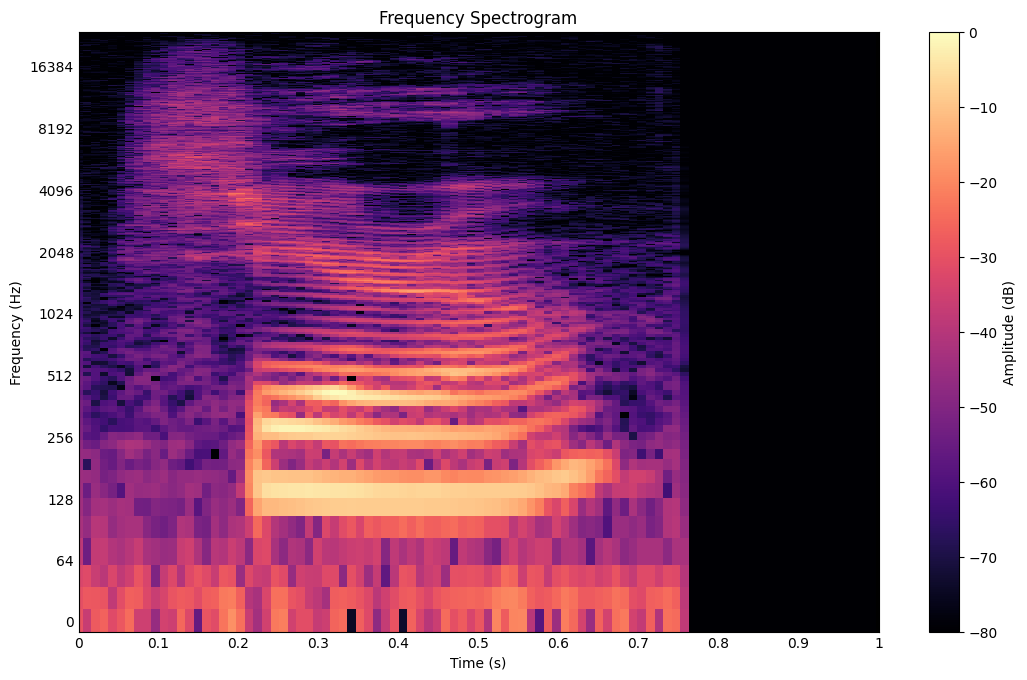

In [ ]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import wave

def frequency_image_generator(filepath):

    # Load the audio file
    audio_file = filepath
    y, sr = librosa.load(audio_file, sr=None)

    # Ensure the audio is at least 1 second long
    target_length = sr * 1  # 1 second of audio at the sample rate (sr)

    if len(y) < target_length:
        # Pad the signal with zeros if the audio is shorter than 1 second
        y = np.pad(y, (0, target_length - len(y)), mode='constant')
    else:
        # Trim to exactly 1 second if the audio is longer
        y = y[:target_length]

    # Perform Short-Time Fourier Transform (STFT)
    D = librosa.stft(y)
    
    # Convert amplitude to decibels (optional)
    DB = librosa.amplitude_to_db(np.abs(D), ref=np.max)


    # Plot the dominant frequency over time
    plt.figure(figsize=(10, 6))
    librosa.display.specshow(DB, x_axis='time', y_axis='log', sr=sr)

    plt.colorbar(label='Amplitude (dB)')
    plt.title('Frequency Spectrogram')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.xlim(0, 1)  # Limit the time axis to 1 second
    plt.grid(False)

    # Remove all axis ticks and labels
    plt.tick_params(axis='both', which='both', length=0)  # Removes ticks on both axes
    
    # Remove extra whitespace
    plt.subplots_adjust(left=0, right=1, top=1, bottom=0)  # Remove margins

    # Set the background color of the plot to black to remove white space around the plot
    plt.gca().set_facecolor('black')

    # Save the plot without extra whitespace (if saving the figure)
    #plt.savefig('spectrogram.png', bbox_inches='tight', pad_inches=0)  # This removes the white space when saving

    plt.show()



def get_wav_length(file_path):
    with wave.open(file_path, 'rb') as wav_file:
        frames = wav_file.getnframes()  # total number of frames
        rate = wav_file.getframerate()  # frames per second (frame rate)
        duration = frames / float(rate)  # duration in seconds
    return duration




def get_filemax(df):

    filemax = 9999
    num_good_files = 0

    for i in range(len(df['Label'])):

        row = df.loc[i]
        label = row['Label']
        file = row['File Name']

        filepath = main_folder_path + '/' + label + '/' + file

        file_len = get_wav_length(filepath)

        if (file_len >= 1):
            num_good_files += 1

            if (file_len < filemax):
                filemax = file_len

    return filemax





def get_frequency_images(df):

    frequency_images = []

    filemax = get_filemax(df)

    for i in range(1):

        row = df.loc[i]
        label = row['Label']
        file = row['File Name']

        filepath = main_folder_path + '/' + label + '/' + file


        audio_file = filepath
        y, sr = librosa.load(audio_file, sr=None)
        # Ensure the audio is at least 1 second long
        target_length = sr * 1  # 1 second of audio at the sample rate (sr)
        if len(y) < target_length:
            # Pad the signal with zeros if the audio is shorter than 1 second
            y = np.pad(y, (0, target_length - len(y)), mode='constant')
        else:
            # Trim to exactly 1 second if the audio is longer
            y = y[:target_length]
        # Perform Short-Time Fourier Transform (STFT)
        D = librosa.stft(y)
        # Convert amplitude to decibels (optional)
        DB = librosa.amplitude_to_db(np.abs(D), ref=np.max)


        #frequency_image_generator(filepath)


get_frequency_images(df)






In [1]:
import os
import pandas as pd
import librosa
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
import numpy as np
import librosa.display
from torchvision import datasets, models, transforms

# Function to load subfolders and file names
def get_subfolder_names(main_folder_path):
    file_names = []
    subfolder_names = []

    for folder_ID in os.listdir(main_folder_path):
        subfolder_path = main_folder_path + '/' + folder_ID
        
        for file_ID in os.listdir(subfolder_path):
            if os.path.isdir(os.path.join(main_folder_path, folder_ID)):
                subfolder_names.append(folder_ID)
            if os.path.isfile(os.path.join(subfolder_path, file_ID)):
                file_names.append(file_ID)
    
    return [subfolder_names, file_names]

# Reading the data paths and labels
main_folder_path = "C:/Users/ryan_/OneDrive/Documents/USF/Courses/Fall 2024/Mobile Biometrics/Project/Voice Recognition/data"
subfolders = get_subfolder_names(main_folder_path)[0]
fileNames = get_subfolder_names(main_folder_path)[1]

data = {'Label':subfolders, 'File Name':fileNames}
df = pd.DataFrame(data)

# Dataset class to generate spectrograms
class SpectrogramDataset(Dataset):
    def __init__(self, df, main_folder_path, transform=None):
        self.df = df
        self.main_folder_path = main_folder_path
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.loc[idx]
        label = row['Label']
        file = row['File Name']
        filepath = os.path.join(self.main_folder_path, label, file)

        # Load audio file
        y, sr = librosa.load(filepath, sr=None)

        # Ensure audio is at least 1 second long
        target_length = sr * 1
        if len(y) < target_length:
            y = np.pad(y, (0, target_length - len(y)), mode='constant')
        else:
            y = y[:target_length]

        # Perform Short-Time Fourier Transform (STFT)
        D = librosa.stft(y)
        DB = librosa.amplitude_to_db(np.abs(D), ref=np.max)

        # Convert to a tensor
        spectrogram = torch.tensor(DB, dtype=torch.float32)

        # Apply any transforms (e.g., normalization, resizing)
        if self.transform:
            spectrogram = self.transform(spectrogram)

        return spectrogram, label

# Transform to normalize the spectrograms to a range suitable for training
transform = transforms.Compose([
    transforms.Lambda(lambda x: x.unsqueeze(0)),  # Add a channel dimension (ResNet expects 3 channels)
])

# Create dataset and split into train, val, and test sets
dataset = SpectrogramDataset(df, main_folder_path, transform=transform)

# Split dataset into train (80%), validation (10%), and test (10%)
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

# Create DataLoader for batching
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Example: iterate through one batch
for inputs, labels in train_loader:
    print(inputs.shape)  # Should print something like (64, 1, H, W) - where H and W are the spectrogram dimensions
    break


torch.Size([64, 1, 1025, 94])


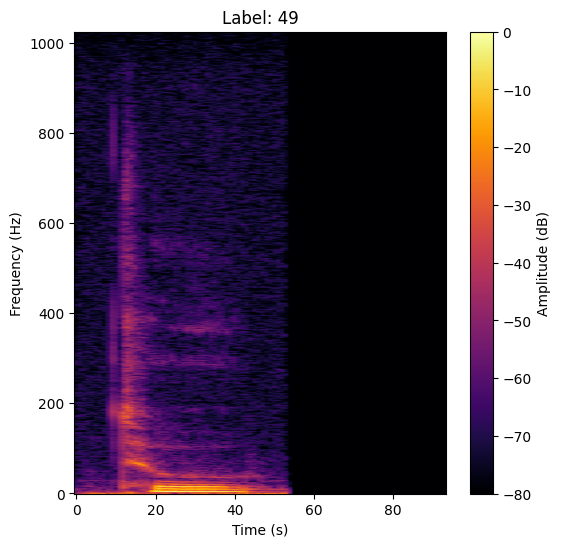

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Get a batch of data from the train_loader
for inputs, labels in train_loader:
    # Get the first image in the batch
    img = inputs[0].squeeze(0).numpy()  # Remove the channel dimension and convert to NumPy
    label = labels[0]  # Get the label for the first image
    break

# Plot the spectrogram
plt.figure(figsize=(6, 6))
plt.imshow(img, cmap='inferno', origin='lower', aspect='auto')  # Using the 'inferno' colormap for better visualization
plt.colorbar(label='Amplitude (dB)')
plt.title(f'Label: {label}')  # Show the label on the plot
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.show()


In [8]:
import os
import pandas as pd
import librosa
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

# Step 1: Read data and prepare labels and file paths
def get_subfolder_names(main_folder_path):
    file_names = []
    subfolder_names = []
    for folder_ID in os.listdir(main_folder_path):
        subfolder_path = os.path.join(main_folder_path, folder_ID)
        for file_ID in os.listdir(subfolder_path):
            if os.path.isdir(subfolder_path):
                subfolder_names.append(folder_ID)
            if os.path.isfile(os.path.join(subfolder_path, file_ID)):
                file_names.append(file_ID)
    return subfolder_names, file_names

# Load all subfolder and file names into a DataFrame
main_folder_path = "C:/Users/ryan_/OneDrive/Documents/USF/Courses/Fall 2024/Mobile Biometrics/Project/Voice Recognition/data"
subfolders, file_names = get_subfolder_names(main_folder_path)
data = {'Label': subfolders, 'File Name': file_names}
df = pd.DataFrame(data)

# Step 2: Generate spectrograms and split the dataset
class VoiceDataset(Dataset):
    def __init__(self, df, main_folder_path, transform=None):
        self.df = df
        self.main_folder_path = main_folder_path
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        label = row['Label']
        file = row['File Name']

        filepath = os.path.join(self.main_folder_path, label, file)
        y, sr = librosa.load(filepath, sr=None)

        # Ensure the audio is at least 1 second long
        target_length = sr * 1  # 1 second of audio
        if len(y) < target_length:
            y = np.pad(y, (0, target_length - len(y)), mode='constant')
        else:
            y = y[:target_length]

        # Perform Short-Time Fourier Transform (STFT)
        D = librosa.stft(y)
        DB = librosa.amplitude_to_db(np.abs(D), ref=np.max)

        # Convert the spectrogram to a tensor and normalize if needed
        spectrogram = torch.tensor(DB, dtype=torch.float32)

        if self.transform:
            spectrogram = self.transform(spectrogram)

        return spectrogram, label

# Step 3: Split data by person and create train, validation, test sets
# Create a mapping of subfolders (people) to file paths
people_data = {}
for _, row in df.iterrows():
    label = row['Label']
    file = row['File Name']
    filepath = os.path.join(main_folder_path, label, file)
    
    if label not in people_data:
        people_data[label] = []
    people_data[label].append(filepath)

# Randomly select 40 people out of 60
selected_people = np.random.choice(list(people_data.keys()), size=40, replace=False)

# Split files for each selected person into train, val, and test sets
train_files, val_test_files = [], []
for person in selected_people:
    person_files = people_data[person]
    train_size = int(0.8 * len(person_files))
    val_size = int(0.1 * len(person_files))
    
    # Split data for each person
    train_files.extend(person_files[:train_size])
    val_test_files.extend(person_files[train_size:])
    
# Further split the remaining 10% into val and test sets
val_files, test_files = train_test_split(val_test_files, test_size=0.5)

# Combine the files into DataFrames
train_df = pd.DataFrame({'File Name': train_files, 'Label': [file.split('/')[-2] for file in train_files]})
val_df = pd.DataFrame({'File Name': val_files, 'Label': [file.split('/')[-2] for file in val_files]})
test_df = pd.DataFrame({'File Name': test_files, 'Label': [file.split('/')[-2] for file in test_files]})

# Step 4: Create DataLoaders for training, validation, and test sets

train_dataset = VoiceDataset(train_df, main_folder_path)
val_dataset = VoiceDataset(val_df, main_folder_path)
test_dataset = VoiceDataset(test_df, main_folder_path)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# The datasets and dataloaders are now ready to be used with a model for training


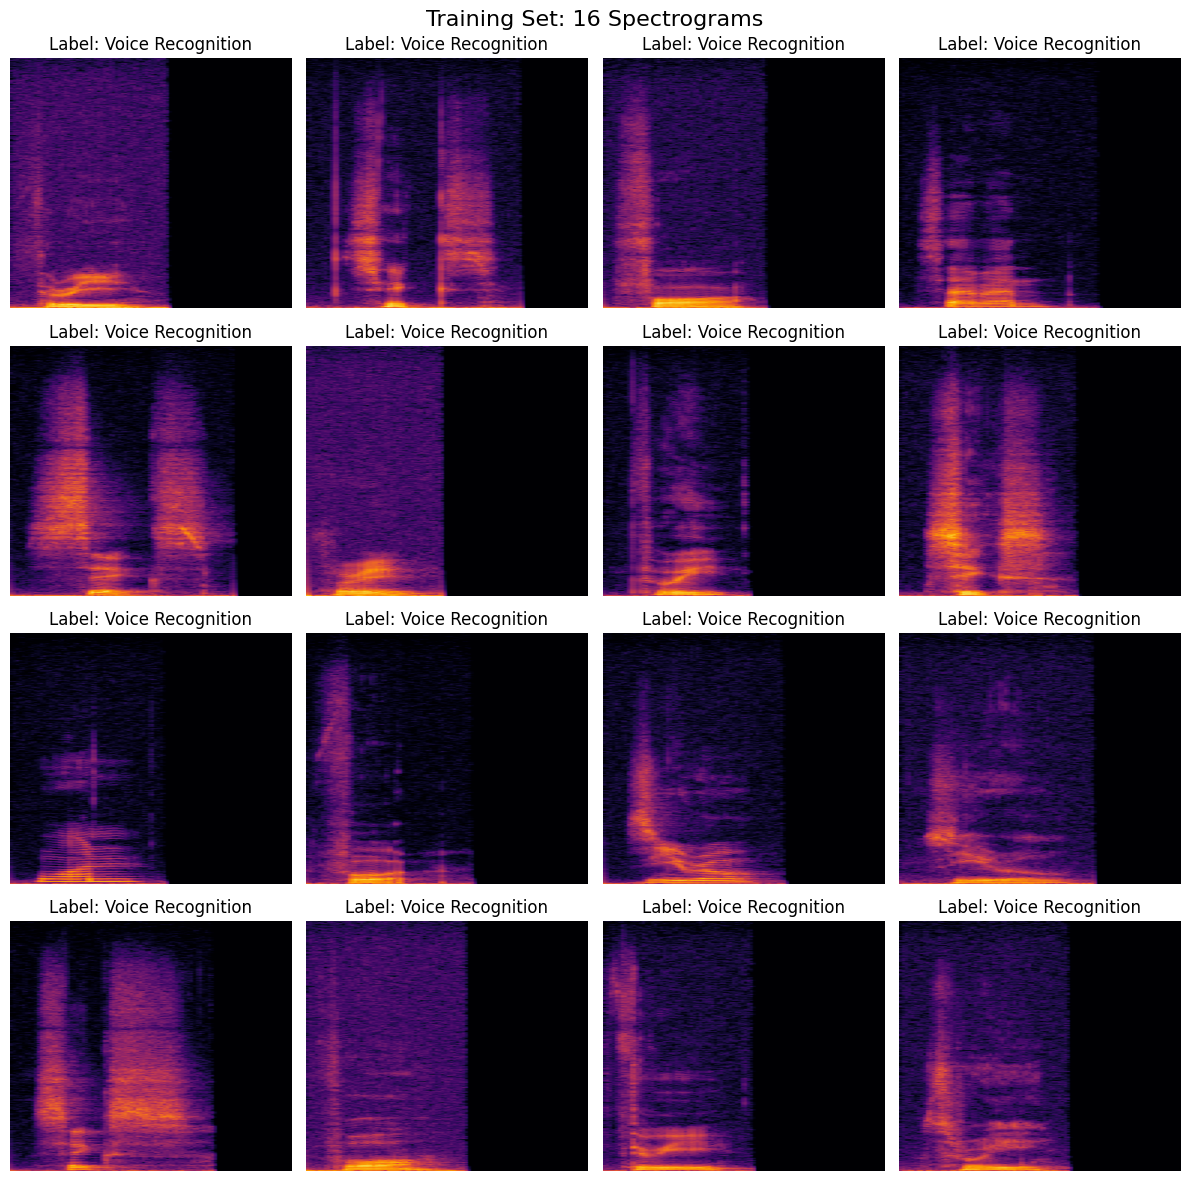

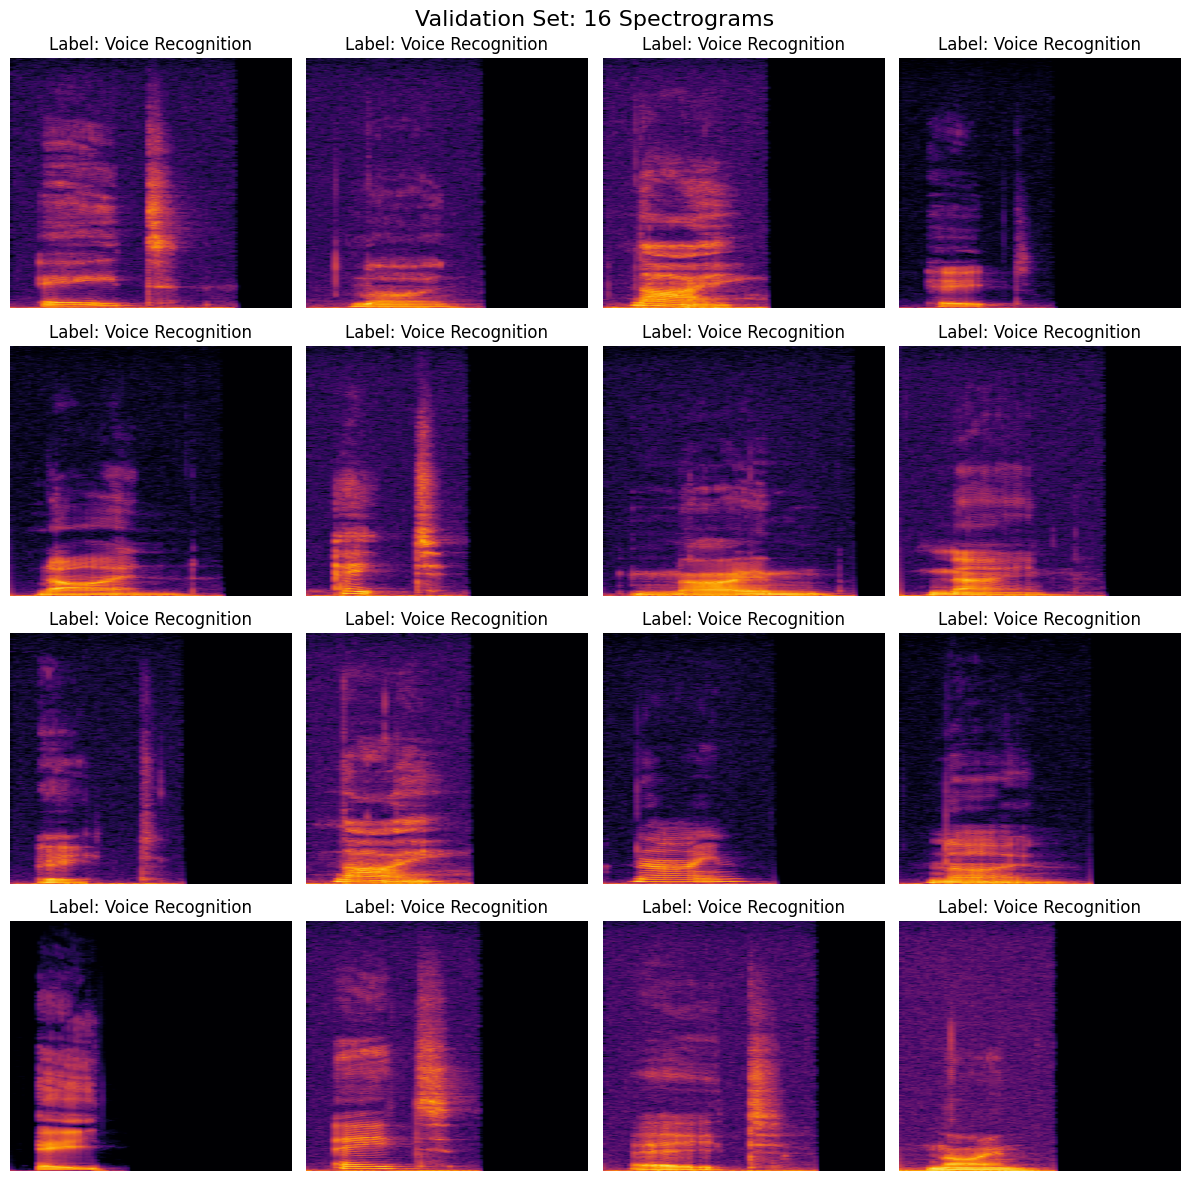

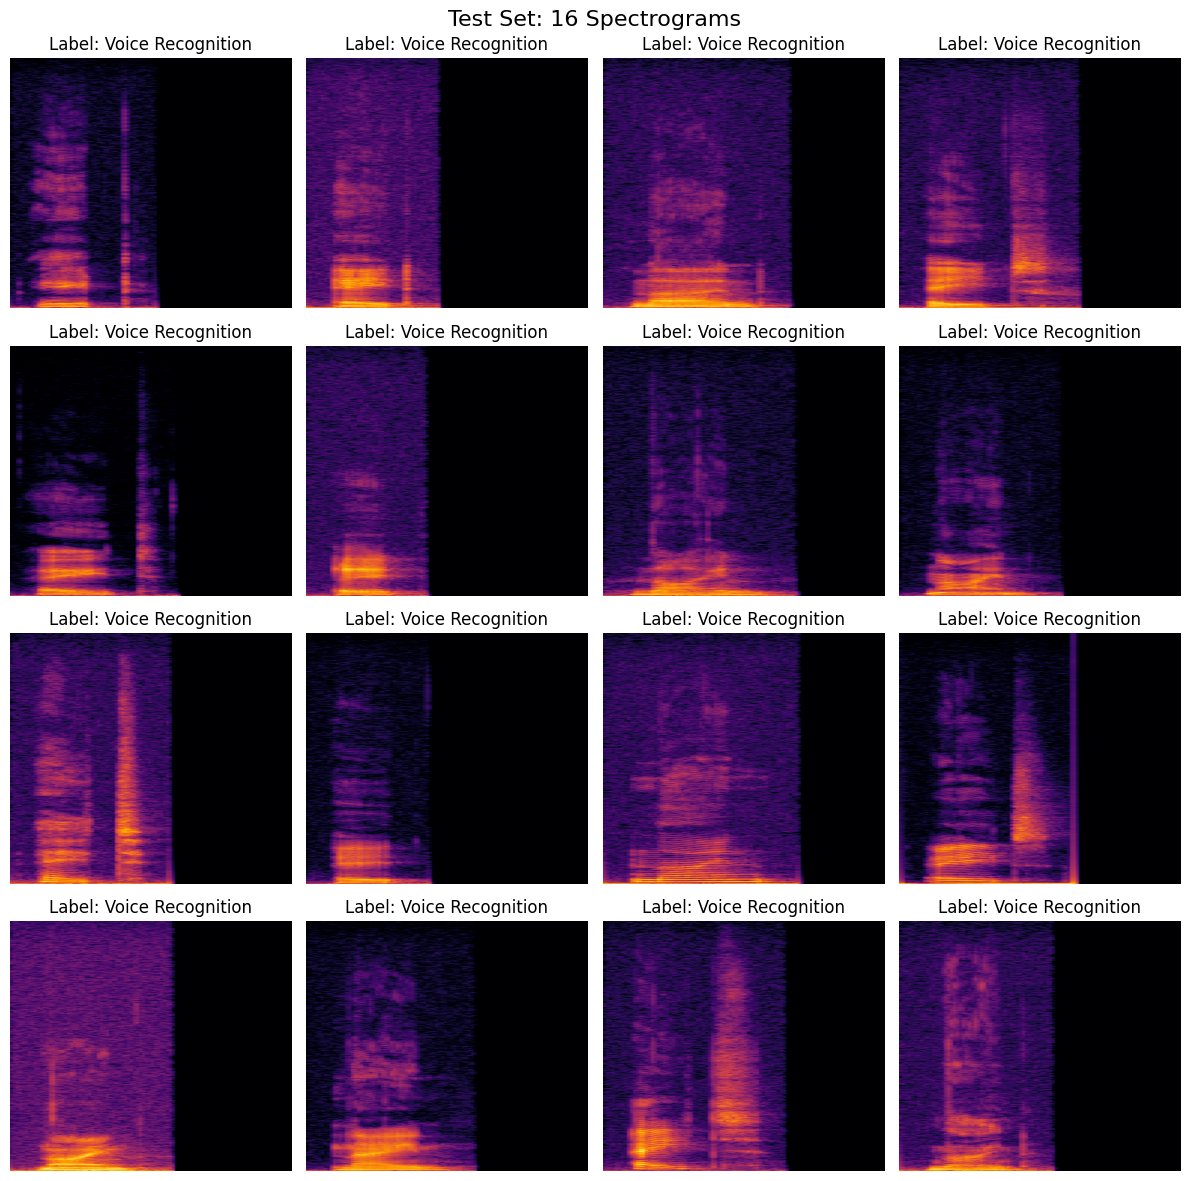

In [9]:
import matplotlib.pyplot as plt
import numpy as np

def plot_spectrograms(dataloader, title, n_images=16):
    # Set up the plot
    fig, axes = plt.subplots(4, 4, figsize=(12, 12))  # 4x4 grid of subplots
    axes = axes.flatten()  # Flatten the axes for easy iteration

    # Iterate through the dataloader and plot 16 images
    for i, (spectrograms, labels) in enumerate(dataloader):
        if i >= 1:  # We only need the first batch
            break

        # Randomly select 16 spectrograms from the batch
        random_indices = np.random.choice(len(spectrograms), size=n_images, replace=False)

        for j, idx in enumerate(random_indices):
            ax = axes[j]
            spec = spectrograms[idx].numpy()

            # Plot the spectrogram
            ax.imshow(spec, aspect='auto', cmap='inferno', origin='lower')
            ax.set_title(f'Label: {labels[idx]}')
            ax.axis('off')  # Hide axis ticks and labels

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

# Step 1: Plot 16 images for one person in the training set
# Here, you would want to ensure that you are selecting data from the same person
# For simplicity, we are assuming that the DataLoader contains the data you need.
plot_spectrograms(train_loader, "Training Set: 16 Spectrograms")

# Step 2: Plot 16 images for one person in the validation set
plot_spectrograms(val_loader, "Validation Set: 16 Spectrograms")

# Step 3: Plot 16 images for one person in the test set
plot_spectrograms(test_loader, "Test Set: 16 Spectrograms")


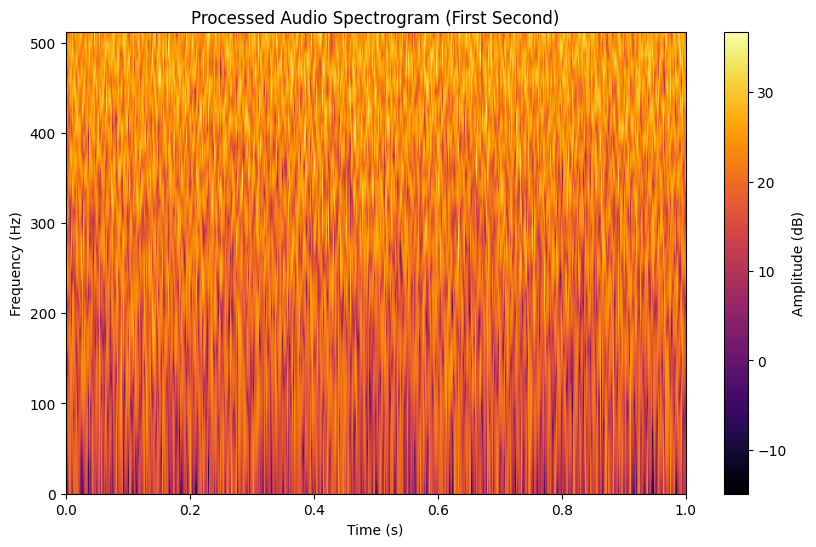

In [87]:
import torch
import torchaudio
import torchaudio.transforms as T
import numpy as np
import matplotlib.pyplot as plt

class AudioProcessor:
    def __init__(self, mel=True, sample_rate=16000, win_length=60, hop_length=1):
        self.mel = mel
        self.sample_rate = sample_rate
        self.win_length = win_length
        self.hop_length = hop_length

    def process_audio(self, audio_sample):
        # Ensure audio_sample is a tensor with the audio signal
        if not isinstance(audio_sample, torch.Tensor):
            raise ValueError(f"Expected audio_sample to be a tensor, but got {type(audio_sample)}")

        # Get the audio signal and sample rate
        audio_signal = audio_sample
        sample_rate = self.sample_rate

        # Slice to get the first second of audio (if applicable)
        audio_signal = audio_signal[:sample_rate]  # Use only the first second (sample_rate corresponds to 1 second)

        # Calculate n_fft from window length and sample rate
        nfft = int(self.win_length * sample_rate // 1000)

        # Compute the spectrogram using STFT
        specgram = torchaudio.transforms.MelSpectrogram(
            sample_rate=sample_rate, 
            n_fft=nfft, 
            win_length=self.win_length,
            hop_length=self.hop_length,
            n_mels=50
        )(audio_signal)

        # Apply Mel scaling (if mel is enabled)
        if self.mel:
            mel_transform = torchaudio.transforms.MelScale(n_mels=50, sample_rate=sample_rate, n_stft=nfft//2 + 1)
            mel_spec = mel_transform(specgram)
            mel_spec = 10.0 * torch.log10(torch.maximum(mel_spec, torch.full(mel_spec.size(), fill_value=1e-10)))
            spectrogram = mel_spec
        else:
            spectrogram = 10.0 * torch.log10(torch.maximum(specgram, torch.full(specgram.size(), fill_value=1e-10)))
        
        # Resize the spectrogram for visualization or network input
        spectrogram = torch.nn.functional.interpolate(spectrogram.unsqueeze(0).unsqueeze(0), size=(512, 512), mode='bilinear', align_corners=False).squeeze(0).squeeze(0)

        return spectrogram

    def plot_spectrogram(self, spectrogram, title="Spectrogram"):
        # Convert to numpy for plotting
        spectrogram_np = spectrogram.cpu().detach().numpy()

        # Plot the spectrogram for only the first second of the audio
        plt.figure(figsize=(10, 6))
        plt.imshow(spectrogram_np, aspect='auto', cmap='inferno', origin='lower', extent=[0, 1, 0, spectrogram_np.shape[0]])
        plt.colorbar(label='Amplitude (dB)')
        plt.title(title)
        plt.xlabel('Time (s)')
        plt.ylabel('Frequency (Hz)')
        plt.show()

# Usage Example:

# Example audio sample tensor (you'd replace this with real data)
audio_sample = torch.randn(16000)  # 1 second of dummy data with a sample rate of 16000

# Create an instance of the processor
processor = AudioProcessor(mel=False, sample_rate=16000, win_length=60, hop_length=1)

# Process the audio sample and get the spectrogram
spectrogram = processor.process_audio(audio_sample)

# Plot the spectrogram for the first second
processor.plot_spectrogram(spectrogram, title="Processed Audio Spectrogram (First Second)")
